# TRF Tutorial

In this notebook we show how to import word onset as a word-level feature and compute TRF from them.

In [1]:
import os
from functools import reduce
from scipy.io import loadmat
from scipy.stats import zscore
from pyeeg.io import eeglab2mne
from pyeeg.models import TRFEstimator
import logging

# Set high logger level:
logging.getLogger().setLevel(logging.ERROR)

subj_id = 3 # id of participant (3 is subject P04)
story_id = 1 # id of stories (1 is AUNP02)

## Single subject, single story

### Import EEG

In [2]:
%gui qt

from PyQt5.QtWidgets import QFileDialog

def gui_fname(dir=None):
    """Select a directory."""
    if dir is None: dir ='./'
    fname = QFileDialog.getExistingDirectory(None, "Select directory...", dir)
    return fname

In [3]:
try:
    experiment_path = '/media/hw2512/SeagateExpansionDrive/EEG_data/Katerina_experiment'
    os.listdir('/media/hw2512/SeagateExpansionDrive/EEG_data/Katerina_experiment')
except:
    experiment_path = gui_fname()

In [4]:
eeg_path = os.path.join(experiment_path, "Processed/Fs-125/interp_bad/BP-0.3-65/Blink_pruned/")
list_subjects = os.listdir(eeg_path)
eeg_fname = [f for f in os.listdir(os.path.join(eeg_path, list_subjects[subj_id])) if f.endswith('.set')][0]

event_id = dict(boundary=-1, story_onset=1)
raw = eeglab2mne(os.path.join(eeg_path, list_subjects[subj_id], eeg_fname), load_ica=False, event_id=event_id)
raw.pick_types(eeg=True)

# Filtering the EEG
raw = raw.filter(1, 15, n_jobs=2)

1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.


/home/hw2512/MachineLearning/Playground/EEG Analysis/pyEEG/pyeeg/io.py:184: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


### Import Word-level features

We will load _surprisal_ feature and fit a TRF model on both _word onsets_ and _surprisal_ word features.

In [5]:
# Import all paths
from pyeeg.io import WordLevelFeatures, AlignedSpeech

stim_path = os.path.join(experiment_path, 'story_parts')
audio_path = os.path.join(stim_path, 'alignement_data/')
syntfeat_path = os.path.join(stim_path, 'syntactic_depth/')
list_synt_files = [item for item in os.listdir(syntfeat_path) if item.endswith('.csv')]
list_stories = [item.strip('_allsynt.csv') for item in list_synt_files]
list_audio_files = [os.path.join(audio_path, s, s + '.wav') for s in list_stories]

# Sort them all in case:
for l in [list_audio_files, list_stories, list_synt_files]:
    l.sort()

onset_path = './all_katerina_onsets.mat'
onsets = loadmat(onset_path)['onsets']

# Loading word onset and duration for AUNP02:
wo_path = os.path.join(syntfeat_path, list_synt_files[story_id])
duration_path = list_audio_files[story_id]
synt_path = os.path.join(syntfeat_path, list_synt_files[story_id])

In [6]:
# Create word-level feature object:
speech = AlignedSpeech(path_audio=duration_path, onset=onsets[subj_id, story_id], srate=raw.info['sfreq'])
speech.create_word_level_features(use_wordonsets=True, path_syntactic=synt_path,
                                 path_wordonsets=wo_path)

# Creating feature matrix
x = speech.feats.get_values()

# Getting EEG data
y = raw.get_data()

# Croping data with indices that match current story for this participant
indices = speech.indices
y = y[:, indices].T

## Run TRF modelling

The TRFEstimator class allows to use any arbitrary set of lags. The lagged time series design matrix
will be generated when fitting the class instance to aligned EEG and feature data.

In [11]:
# TRF instance
reg_param = 0. # Ridge parameter
trf = TRFEstimator(tmin=-0.6, tmax=0.8, srate=raw.info['sfreq'], alpha=reg_param)

# Fit our model
trf.fit(x, y, feat_names=["Word Onsets", "Depth", "Open", "Close"])

TRFEstimator(alpha=0.0, fit_intercept=True, srate=125.0,
       times=array([-0.592, -0.584, ...,  0.792,  0.8  ]), tmax=None,
       tmin=None)

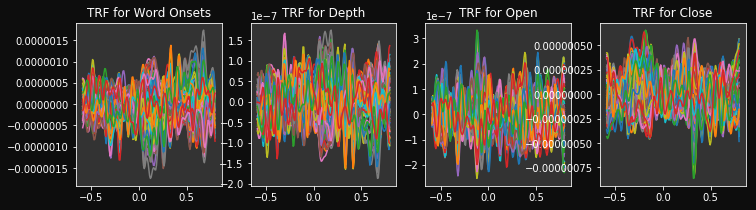

In [21]:
# Plot model:
trf.plot(feat_id=range(trf.n_feats_), figsize=(12,3))

## Average several models

Let's loop the computation over all subjects and all stories to compute and grand average TRF.

In [22]:
coefs = []

# Loop over subject
for subj_id, subj in enumerate(list_subjects):
    print("="*30 + " Processing subject %s"%(subj) + "=" * 20)
    eeg_fname = [f for f in os.listdir(os.path.join(eeg_path, list_subjects[subj_id])) if f.endswith('.set')][0]
    
    # Import and process EEG:
    raw = eeglab2mne(os.path.join(eeg_path, list_subjects[subj_id], eeg_fname), load_ica=False, event_id=event_id)
    raw.pick_types(eeg=True)
    raw = raw.filter(1, 15, n_jobs=2)
    y = raw.get_data()
    
    # Loop over stories
    for story_id, story in enumerate(list_stories):
        print("\t"*4 + "... %s"%(story))
        wo_path = os.path.join(syntfeat_path, list_synt_files[story_id])
        duration_path = list_audio_files[story_id]
        synt_path = os.path.join(syntfeat_path, list_synt_files[story_id])

        # Create word-level feature object:
        speech = AlignedSpeech(path_audio=duration_path, onset=onsets[subj_id, story_id], srate=raw.info['sfreq'])
        speech.create_word_level_features(use_wordonsets=True, path_syntactic=synt_path,
                                         path_wordonsets=wo_path)
        # Creating feature matrix
        x = speech.feats.get_values()
        # Croping data with indices that match current story for this participant
        indices = speech.indices

        # Perform the fit:
        trf = TRFEstimator(tmin=-0.6, tmax=0.8, srate=raw.info['sfreq'], alpha=reg_param)
        trf.fit(x, y[:, indices].T, feat_names=["Word Onsets", "Depth", "Open", "Close"])
        
        coefs.append(trf.coef_)

============================== Processing subject P01_bis====================
				... AUNP01
				... AUNP02
				... AUNP03
				... AUNP04
				... AUNP05
				... AUNP06
				... AUNP07
				... AUNP08
				... BROP01
				... BROP02
				... BROP03
				... FLOP01
				... FLOP02
				... FLOP03
				... FLOP04
============================== Processing subject P02_11072016====================
1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.


/home/hw2512/MachineLearning/Playground/EEG Analysis/pyEEG/pyeeg/io.py:184: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


				... AUNP01
				... AUNP02
				... AUNP03
				... AUNP04
				... AUNP05
				... AUNP06
				... AUNP07
				... AUNP08
				... BROP01
				... BROP02
				... BROP03
				... FLOP01
				... FLOP02
				... FLOP03
				... FLOP04
============================== Processing subject P03_12072016====================
				... AUNP01
				... AUNP02
				... AUNP03
				... AUNP04
				... AUNP05
				... AUNP06
				... AUNP07
				... AUNP08
				... BROP01
				... BROP02
				... BROP03
				... FLOP01
				... FLOP02
				... FLOP03
				... FLOP04
============================== Processing subject P04_13072016====================
1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.


/home/hw2512/MachineLearning/Playground/EEG Analysis/pyEEG/pyeeg/io.py:184: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


				... AUNP01
				... AUNP02
				... AUNP03
				... AUNP04
				... AUNP05
				... AUNP06
				... AUNP07
				... AUNP08
				... BROP01
				... BROP02
				... BROP03
				... FLOP01
				... FLOP02
				... FLOP03
				... FLOP04
============================== Processing subject P05_14072016====================
1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.


/home/hw2512/MachineLearning/Playground/EEG Analysis/pyEEG/pyeeg/io.py:184: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


				... AUNP01
				... AUNP02
				... AUNP03
				... AUNP04
				... AUNP05
				... AUNP06
				... AUNP07
				... AUNP08
				... BROP01
				... BROP02
				... BROP03
				... FLOP01
				... FLOP02
				... FLOP03
				... FLOP04
============================== Processing subject P06_18072016====================
				... AUNP01
				... AUNP02
				... AUNP03
				... AUNP04
				... AUNP05
				... AUNP06
				... AUNP07
				... AUNP08
				... BROP01
				... BROP02
				... BROP03
				... FLOP01
				... FLOP02
				... FLOP03
				... FLOP04
============================== Processing subject P07_19072016====================
				... AUNP01
				... AUNP02
				... AUNP03
				... AUNP04
				... AUNP05
				... AUNP06
				... AUNP07
				... AUNP08
				... BROP01
				... BROP02
				... BROP03
				... FLOP01
				... FLOP02
				... FLOP03
				... FLOP04
============================== Processing subject P08_21072016====================
1 events will be dropped because they occur on the same time sample as anoth

/home/hw2512/MachineLearning/Playground/EEG Analysis/pyEEG/pyeeg/io.py:184: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


				... AUNP01
				... AUNP02
				... AUNP03
				... AUNP04
				... AUNP05
				... AUNP06
				... AUNP07
				... AUNP08
				... BROP01
				... BROP02
				... BROP03
				... FLOP01
				... FLOP02
				... FLOP03
				... FLOP04
============================== Processing subject P09_22072016====================
1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.


/home/hw2512/MachineLearning/Playground/EEG Analysis/pyEEG/pyeeg/io.py:184: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


				... AUNP01
				... AUNP02
				... AUNP03
				... AUNP04
				... AUNP05
				... AUNP06
				... AUNP07
				... AUNP08
				... BROP01
				... BROP02
				... BROP03
				... FLOP01
				... FLOP02
				... FLOP03
				... FLOP04
============================== Processing subject P10_14092016====================
				... AUNP01
				... AUNP02
				... AUNP03
				... AUNP04
				... AUNP05
				... AUNP06
				... AUNP07
				... AUNP08
				... BROP01
				... BROP02
				... BROP03
				... FLOP01
				... FLOP02
				... FLOP03
				... FLOP04
============================== Processing subject P12_01092016====================
				... AUNP01
				... AUNP02
				... AUNP03
				... AUNP04
				... AUNP05
				... AUNP06
				... AUNP07
				... AUNP08
				... BROP01
				... BROP02
				... BROP03
				... FLOP01
				... FLOP02
				... FLOP03
				... FLOP04
============================== Processing subject P13_08092016====================
				... AUNP01
				... AUNP02
				... AUNP03
				... AUNP04
				... AUNP05
	

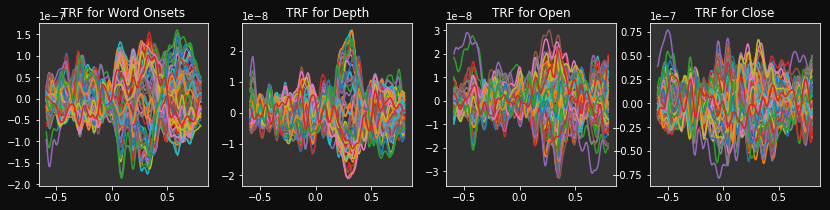

In [23]:
# Average and plug the resulting coef in trf instance for easy plotting
coef_avg = np.mean(np.asarray(coefs), axis=0)
trf.coef_ = coef_avg

trf.plot(feat_id=range(trf.n_feats_), figsize=(14,3))

## Compute one _big_ model

Now, instead of computing a model for each story and each participants, we will compute one _grand_ model trained on the concatenation of all data.

**But...**
This is very greedy in memory. Indeed, storing all the EEG data results in a matrix of roughly 2Gb, then the matrix of features, for two features is approximately 100mb, which then results in a design matrix (i.e. time-lagged version of the features) of 12Gb. The latter is then used in different computation, svd or least-square esitmation, which may involve another copy of the matrix... Hence the memory usage can reach a total of 26Gb!!

However it will give a more robust estimate of the TRFs. Fortunately, the implementation of our TRF estimator, allows for a memory-efficient way to compute the coefficient.

The trick used is to accumulate the covariance and cross-covariance matrices used to compute the pseudo-inverse to fit the model. Thus we cut the bulk of the computation (SVD computation) in smaller pieces. Also it can be noted that since the target is always the same (word from stories, similar across participants) the concatenated word-level features can be stored only once and reused to compute the other matrices.

In [24]:
# Loop over stories to get a big concatenation of each story's word features
X = []
wf = {} # make a dictionnary of those, keys are story id
for story_id, story in enumerate(list_stories):
    print("Loading story's word features for ... %s"%(story))
    wo_path = os.path.join(syntfeat_path, list_synt_files[story_id])
    duration_path = list_audio_files[story_id]
    synt_path = os.path.join(syntfeat_path, list_synt_files[story_id])

    # Create word-level feature object:
    wf[story] = WordLevelFeatures(path_audio=duration_path, path_wordonsets=wo_path, path_syntactic=synt_path)
    X.append(wf[story].align_word_features(srate=raw.info['sfreq'], features=('depth','open','close')))    
    
X = np.concatenate(X)

Loading story's word features for ... AUNP01
Loading story's word features for ... AUNP02
Loading story's word features for ... AUNP03
Loading story's word features for ... AUNP04
Loading story's word features for ... AUNP05
Loading story's word features for ... AUNP06
Loading story's word features for ... AUNP07
Loading story's word features for ... AUNP08
Loading story's word features for ... BROP01
Loading story's word features for ... BROP02
Loading story's word features for ... BROP03
Loading story's word features for ... FLOP01
Loading story's word features for ... FLOP02
Loading story's word features for ... FLOP03
Loading story's word features for ... FLOP04


In [26]:
# Loop over subject
Y = []
for subj_id, subj in enumerate(list_subjects):
    print("="*30 + " Processing subject %s"%(subj) + "=" * 20)
    eeg_fname = [f for f in os.listdir(os.path.join(eeg_path, list_subjects[subj_id])) if f.endswith('.set')][0]
    
    # Import and process EEG:
    raw = eeglab2mne(os.path.join(eeg_path, list_subjects[subj_id], eeg_fname), load_ica=False, event_id=event_id)
    raw.pick_types(eeg=True)
    raw = raw.filter(1, 15, n_jobs=2)
    y = raw.get_data()
    indices = reduce(lambda x,y: x + y, [AlignedSpeech(path_audio=list_audio_files[story_id],
                                                       onset=onsets[subj_id, story_id], srate=raw.info['sfreq']) for story_id, story in enumerate(list_stories)]).indices
    Y.append(zscore(y[:, indices].T))

============================== Processing subject P01_bis====================
============================== Processing subject P02_11072016====================
1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.


/home/hw2512/MachineLearning/Playground/EEG Analysis/pyEEG/pyeeg/io.py:184: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


============================== Processing subject P03_12072016====================
============================== Processing subject P04_13072016====================
1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.


/home/hw2512/MachineLearning/Playground/EEG Analysis/pyEEG/pyeeg/io.py:184: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


============================== Processing subject P05_14072016====================
1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.


/home/hw2512/MachineLearning/Playground/EEG Analysis/pyEEG/pyeeg/io.py:184: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


============================== Processing subject P06_18072016====================
============================== Processing subject P07_19072016====================
============================== Processing subject P08_21072016====================
1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.


/home/hw2512/MachineLearning/Playground/EEG Analysis/pyEEG/pyeeg/io.py:184: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


============================== Processing subject P09_22072016====================
1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.


/home/hw2512/MachineLearning/Playground/EEG Analysis/pyEEG/pyeeg/io.py:184: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


============================== Processing subject P10_14092016====================
============================== Processing subject P12_01092016====================
============================== Processing subject P13_08092016====================
============================== Processing subject P14_21032017====================


In [27]:
# Perform the fit:
trf = TRFEstimator(tmin=-0.6, tmax=0.8, srate=raw.info['sfreq'], alpha=0.)
trf.fit(X, Y, feat_names=["Word Onsets", "Depth", "Open", "Close"])

TRFEstimator(alpha=0.0, fit_intercept=True, srate=125.0,
       times=array([-0.592, -0.584, ...,  0.792,  0.8  ]), tmax=None,
       tmin=None)

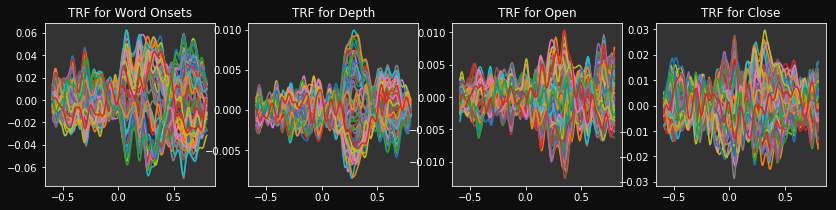

In [29]:
trf.plot(feat_id=[0,1,2,3], figsize=(14,3))

### Comparing with MNE-ReceptiveField

In [30]:
from mne.decoding import ReceptiveField, TimeDelayingRidge
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize as zscore
import mne

In [32]:
# Define the delays that we will use in the receptive field
tmin, tmax = -.6, .8
feat_name = ["Word Onsets", "Depth", "Open", "Close"]
n_feats = len(feat_name)
sfreq = raw.info['sfreq']

# Initialize the model
estimator = TimeDelayingRidge(tmin, tmax, sfreq, #reg_type='laplacian',
                                  alpha=1e-4)
rf = ReceptiveField(tmin, tmax, raw.info['sfreq'], feature_names=feat_name,
                    estimator=estimator, scoring='r2')
# We'll have (tmax - tmin) * sfreq delays
# and an extra 2 delays since we are inclusive on the beginning / end index
n_delays = int((tmax - tmin) * sfreq) + 1
n_channels = 64

n_splits = 5
cv = KFold(n_splits)

mean_coefs = np.zeros((len(list_subjects), n_channels, n_feats, n_delays))
mean_scores = np.zeros((len(list_subjects), n_channels))

for subj in range(len(list_subjects)):
    print("Estimation of coefficients for subject {:s}".format(list_subjects[subj]))
    list_datafiles = os.listdir(os.path.join(eeg_path, list_subjects[subj]))
    eeg_fname = [f for f in list_datafiles if f.endswith('.set')][0]
    eeg = mne.io.eeglab.read_raw_eeglab(input_fname=os.path.join(eeg_path, list_subjects[subj], eeg_fname), montage='standard_1020', event_id=event_id, preload=True)

    eeg.filter(1, 15, h_trans_bandwidth=2, n_jobs=-1)

    y = eeg.copy().pick_types(eeg=True).get_data()
    indices = reduce(lambda x,y: x + y, [AlignedSpeech(path_audio=list_audio_files[story_id],
                                                       onset=onsets[subj, story_id], srate=raw.info['sfreq']) for story_id, story in enumerate(list_stories)]).indices

    # Prepare model data (make time the first dimension)
    y = y[:, indices]  # Outputs for the model
    y = zscore(y.T)

    # Iterate through splits, fit the model, and predict/test on held-out data
    coefs = np.zeros((n_splits, n_channels, n_feats, n_delays))
    scores = np.zeros((n_splits, n_channels))
    for ii, (train, test) in enumerate(cv.split(X)):
        print('split %s / %s' % (ii + 1, n_splits))
        rf.fit(X[train], y[train])
        scores[ii] = rf.score(X[test], y[test])
        # coef_ is shape (n_outputs, n_features, n_delays)
        coefs[ii] = rf.coef_
    times = rf.delays_ / float(rf.sfreq)

    # Average scores and coefficients across CV splits
    mean_coefs[subj] = coefs.mean(axis=0)
    mean_scores[subj,:] = scores.mean(axis=0)

Estimation of coefficients for subject P01_bis
split 1 / 5
split 2 / 5
split 3 / 5
split 4 / 5
split 5 / 5
Estimation of coefficients for subject P02_11072016
1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.


<ipython-input-32-2e5065e9feea>:27: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.
  eeg = mne.io.eeglab.read_raw_eeglab(input_fname=os.path.join(eeg_path, list_subjects[subj], eeg_fname), montage='standard_1020', event_id=event_id, preload=True)


split 1 / 5
split 2 / 5
split 3 / 5
split 4 / 5
split 5 / 5
Estimation of coefficients for subject P03_12072016
split 1 / 5
split 2 / 5
split 3 / 5
split 4 / 5
split 5 / 5
Estimation of coefficients for subject P04_13072016
1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.


<ipython-input-32-2e5065e9feea>:27: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.
  eeg = mne.io.eeglab.read_raw_eeglab(input_fname=os.path.join(eeg_path, list_subjects[subj], eeg_fname), montage='standard_1020', event_id=event_id, preload=True)


split 1 / 5
split 2 / 5
split 3 / 5
split 4 / 5
split 5 / 5
Estimation of coefficients for subject P05_14072016
1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.


<ipython-input-32-2e5065e9feea>:27: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.
  eeg = mne.io.eeglab.read_raw_eeglab(input_fname=os.path.join(eeg_path, list_subjects[subj], eeg_fname), montage='standard_1020', event_id=event_id, preload=True)


split 1 / 5
split 2 / 5
split 3 / 5
split 4 / 5
split 5 / 5
Estimation of coefficients for subject P06_18072016
split 1 / 5
split 2 / 5
split 3 / 5
split 4 / 5
split 5 / 5
Estimation of coefficients for subject P07_19072016
split 1 / 5
split 2 / 5
split 3 / 5
split 4 / 5
split 5 / 5
Estimation of coefficients for subject P08_21072016
1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.


<ipython-input-32-2e5065e9feea>:27: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.
  eeg = mne.io.eeglab.read_raw_eeglab(input_fname=os.path.join(eeg_path, list_subjects[subj], eeg_fname), montage='standard_1020', event_id=event_id, preload=True)


split 1 / 5
split 2 / 5
split 3 / 5
split 4 / 5
split 5 / 5
Estimation of coefficients for subject P09_22072016
1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.


<ipython-input-32-2e5065e9feea>:27: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. You can extract the original event structure using `mne.io.eeglab.read_events_eeglab`. Then, you can e.g. subset the extracted events for constructing epochs.
  eeg = mne.io.eeglab.read_raw_eeglab(input_fname=os.path.join(eeg_path, list_subjects[subj], eeg_fname), montage='standard_1020', event_id=event_id, preload=True)


split 1 / 5
split 2 / 5
split 3 / 5
split 4 / 5
split 5 / 5
Estimation of coefficients for subject P10_14092016
split 1 / 5
split 2 / 5
split 3 / 5
split 4 / 5
split 5 / 5
Estimation of coefficients for subject P12_01092016
split 1 / 5
split 2 / 5
split 3 / 5
split 4 / 5
split 5 / 5
Estimation of coefficients for subject P13_08092016
split 1 / 5
split 2 / 5
split 3 / 5
split 4 / 5
split 5 / 5
Estimation of coefficients for subject P14_21032017
split 1 / 5
split 2 / 5
split 3 / 5
split 4 / 5
split 5 / 5


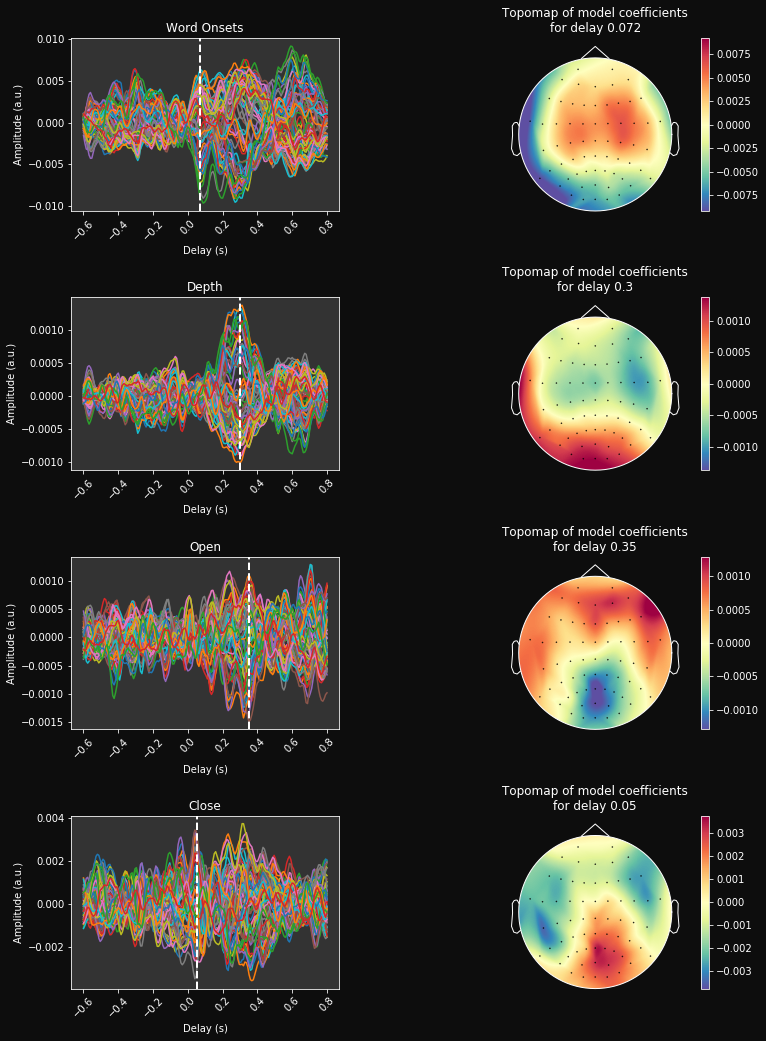

In [34]:
grand_avg_coefs = mean_coefs.mean(0)
cmap='Spectral_r'

# Print mean coefficients across all time delays / channels (see Fig 1 in [1])
time_plot = [0.072, 0.300, 0.350, 0.050]  # For highlighting a specific time.
fig, ax = plt.subplots(figsize=(12, n_feats * 4), ncols=2, nrows=n_feats, gridspec_kw=dict(wspace=0.5, hspace=.5))
for k, f_name in enumerate(feat_name):
    max_coef = grand_avg_coefs[:, k, :].max()
    #ax[0].pcolormesh(times, ix_chs, mean_coefs, cmap=cmap,
    #              vmin=-max_coef, vmax=max_coef, shading='gouraud')
    ax[k, 0].plot(times, grand_avg_coefs[:, k, :].T);
    ax[k, 0].axvline(time_plot[k], ls='--', color='w', lw=2)
    ax[k, 0].set(xlabel='Delay (s)', ylabel='Amplitude (a.u.)', title=f_name)
    plt.setp(ax[k, 0].get_xticklabels(), rotation=45)
    #mne.viz.tight_layout()

    # Make a topographic map of coefficients for a given delay (see Fig 2C in [1])
    ix_plot = np.argmin(np.abs(time_plot[k] - times))
    im, _ = mne.viz.plot_topomap(grand_avg_coefs[:, k, ix_plot], pos=eeg.info, axes=ax[k, 1], show=False, contours=0,
                         vmin=-max_coef, vmax=max_coef, cmap=cmap, res=100)
    plt.colorbar(im, ax=ax[k, 1])
    # Transform head contour in white:
    lines = ax[k, 1].get_lines()
    for L in lines:
        L.set_color('w')
    ax[k, 1].set(title="Topomap of model coefficients\nfor delay %s" % time_plot[k])
#mne.viz.tight_layout()